# Tutorial 1: Integrating adjacent DLPFC slices
This tutorial demonstrates STAligner's ablility to integrate multiple adjacent slices. The slices are sampled from human dorsolateral prefrontal cortex (DLPFC) and the processed data can be downloaded from https://drive.google.com/drive/folders/1pHJy2cB9BKqc3ny9IpvVhiw_8ukJMzPW?usp=share_link.

## Preparation

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
#os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
#os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
import matplotlib.pyplot as plt

import torch
used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [11]:
Batch_list = []
adj_list = []
section_ids = ['151673','151674','151675','151676']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    input_dir = os.path.join('../../../data/DLPFC', section_id)
    adata = sc.read_visium(path=input_dir, count_file=section_id + '_filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join="++")

    # read the annotation
    Ann_df = pd.read_csv(os.path.join(input_dir, 'manual_annotations.txt'), sep='\t', header=None, index_col=0)
    Ann_df.columns = ['Ground Truth']
    Ann_df[Ann_df.isna()] = "unknown"
    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')
    
    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    
    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

['151673', '151674', '151675', '151676']
151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [12]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs['Ground Truth'] = adata_concat.obs['Ground Truth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (14364, 1125)


## Concat the spatial network for multiple slices

In [13]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)

## Running STAligner

In [14]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 50, device=used_device)

STAligner(
  (conv1): GATConv(1125, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1125, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:06<00:00, 80.94it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 500/500 [00:11<00:00, 42.15it/s]

CPU times: total: 1min 37s
Wall time: 18.2 s


## Clustering

In [15]:
STAligner.ST_utils.mclust_R(adata_concat, num_cluster=7, used_obsm='STAligner')
adata_concat = adata_concat[adata_concat.obs['Ground Truth']!='unknown']

from sklearn.metrics import adjusted_rand_score as ari_score
print('mclust, ARI = %01.3f' % ari_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))

fitting ...
  |======================================================================| 100%
mclust, ARI = 0.605


In [16]:
for name in section_ids:
    sub_adata_tmp = adata_concat[adata_concat.obs['batch_name'] == name]
    ARI = ari_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    print(f"{name} ARI:{ARI}")

151673 ARI:0.5841476537757779
151674 ARI:0.6430440808242818
151675 ARI:0.5920958982592908
151676 ARI:0.6120045483202643


In [9]:
from sklearn.metrics import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_mutual_info_score as ami_score
from sklearn.metrics import homogeneity_score as hom_score
from sklearn.metrics import completeness_score as com_score
from my6_Triplet.utils import compute_PAS, compute_CHAOS

print('mclust, Total NMI = %01.3f' % nmi_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
print('mclust, Total AMI = %01.3f' % ami_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
for name in section_ids:
    sub_adata_tmp = adata_concat[adata_concat.obs['batch_name'] == name]
    NMI = nmi_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    AMI = ami_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    ACC = 1/2 * (NMI + AMI)
    print(f"{name} Acc:{ACC}")

mclust, Total NMI = 0.681
mclust, Total AMI = 0.680
151673 Acc:0.6877656961502493
151674 Acc:0.7283183291808714
151675 Acc:0.6778583659262192
151676 Acc:0.6882718457397061


In [10]:
print('mclust, Total HOM = %01.3f' % hom_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
print('mclust, Total COM = %01.3f' % hom_score(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust']))
for name in section_ids:
    sub_adata_tmp = adata_concat[adata_concat.obs['batch_name'] == name]
    HOM = hom_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    COM = com_score(sub_adata_tmp.obs['Ground Truth'], sub_adata_tmp.obs['mclust'])
    V = 2*(HOM*COM)/(HOM+COM)
    print(f"{name} V:{V}")

mclust, Total HOM = 0.683
mclust, Total COM = 0.683
151673 V:0.6881939706314916
151674 V:0.7286873142736271
151675 V:0.6782957578920362
151676 V:0.6887140186675198


2.196143221214711
1.1609810604882174


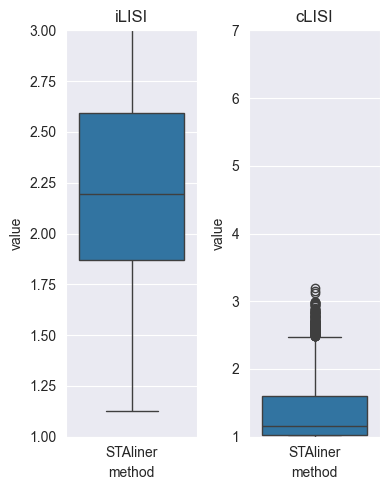

In [11]:
import seaborn as sns
import harmonypy as hm
import matplotlib.pyplot as plt

iLISI = hm.compute_lisi(adata_concat.obsm['STAligner'], adata_concat.obs[['batch_name']], label_colnames=['batch_name'])[:, 0]
cLISI = hm.compute_lisi(adata_concat.obsm['STAligner'], adata_concat.obs[['Ground Truth']], label_colnames=['Ground Truth'])[:, 0]

df_iLISI = pd.DataFrame({
    'method': 'STAliner',
    'value': iLISI,
    'type': ['ILISI'] * len(iLISI)
})

df_cLISI = pd.DataFrame({
    'method': 'STAliner',
    'value': cLISI,
    'type': ['CLISI'] * len(cLISI)
})

fig, axes = plt.subplots(1, 2, figsize=(4, 5))
sns.boxplot(data=df_iLISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_cLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()
print(np.median(iLISI))
print(np.median(cLISI))

## Visualization

In [21]:
plt.rcParams['axes.facecolor'] = 'white'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'white'  # 设置整张图的背景颜色

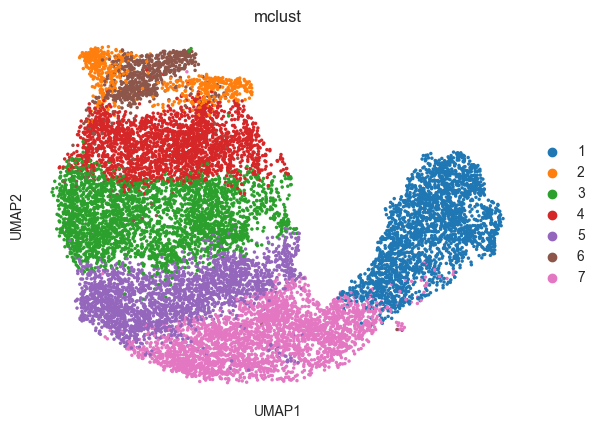

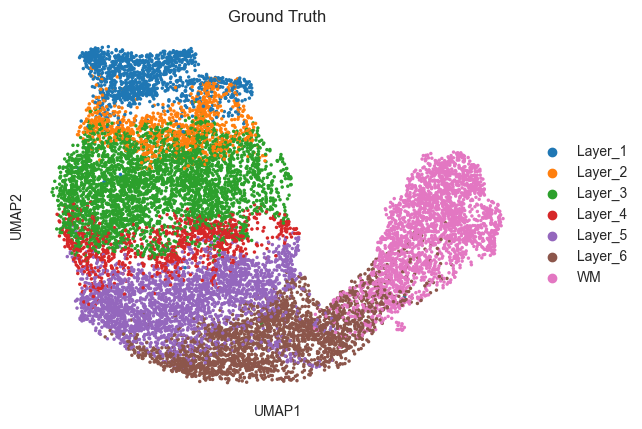

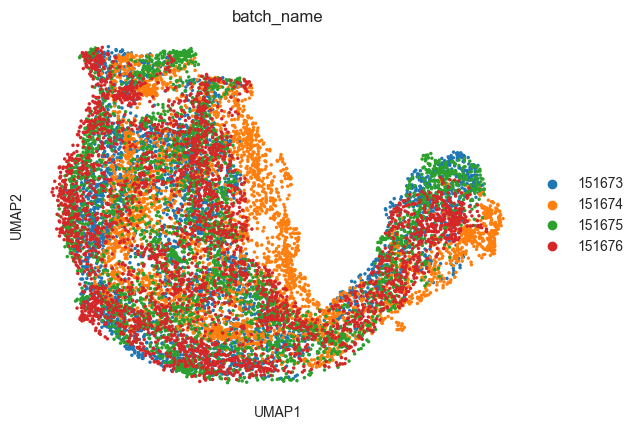

In [22]:
sc.pp.neighbors(adata_concat, use_rep='STAGATE', metric='cosine', n_neighbors=20)
sc.tl.umap(adata_concat)
sc.pl.umap(adata_concat, color=['mclust'], show=True, size=25, save=False)
sc.pl.umap(adata_concat, color=['Ground Truth'], show=True, size=25, save=False)
sc.pl.umap(adata_concat, color=['batch_name'], show=True, size=25, save=False)

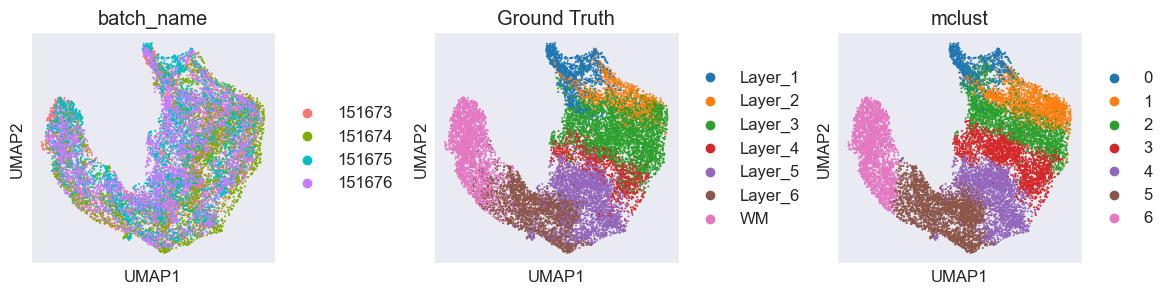

In [13]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]
adata_concat.obs['mclust'] = pd.Series(STAligner.ST_utils.match_cluster_labels(adata_concat.obs['Ground Truth'], adata_concat.obs['mclust'].values),
                                         index=adata_concat.obs.index, dtype='category')

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 12

sc.pl.umap(adata_concat, color=['batch_name', 'Ground Truth', 'mclust'], ncols=3, 
           wspace=0.5, show=True)

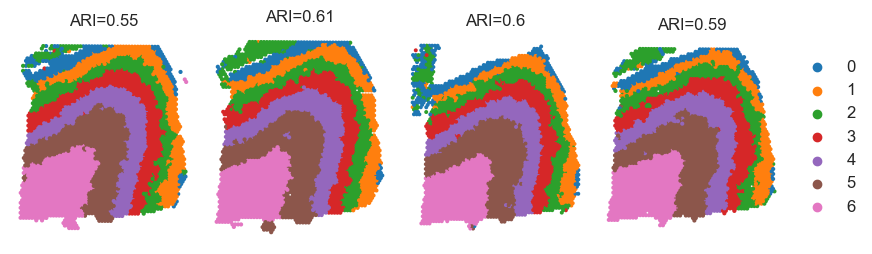

In [14]:
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['Ground Truth'], Batch_list[bb].obs['mclust']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['mclust'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()

In [28]:
plt.rcParams['axes.facecolor'] = 'lightgray'  # 设置子图的背景颜色
plt.rcParams['figure.facecolor'] = 'lightgray'  # 设置整张图的背景颜色

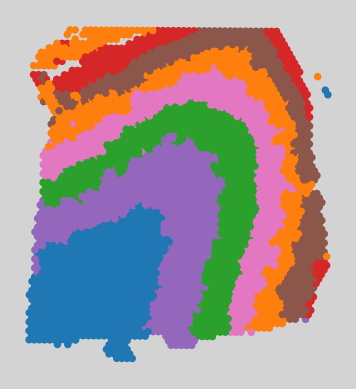

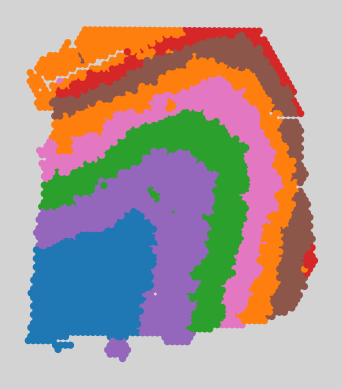

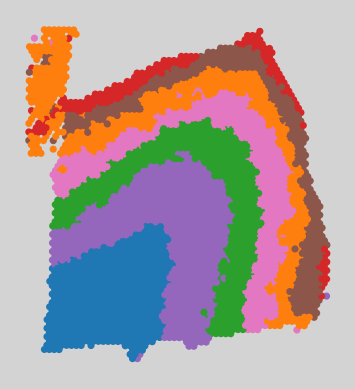

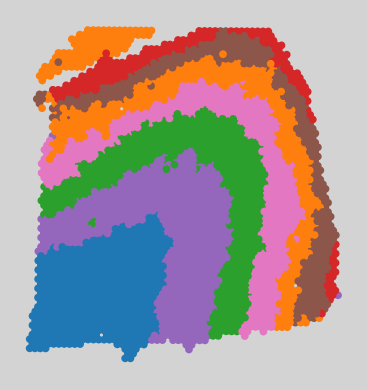

In [29]:
for section_id in section_ids:
    adata_tmp = adata_concat[adata_concat.obs['batch_name'] == section_id]
    sc.pl.spatial(adata_tmp, img_key=None, color=['mclust'], title=[''],
                      legend_fontsize=12, show=False, frameon=False, legend_loc=None,
                      spot_size=200)
    
    plt.savefig('STAlinear_'+section_id+'.png', dpi=300, bbox_inches='tight')

In [34]:
#adata_concat.write('STAliner_Donor3.h5ad')

IORegistryError: No method registered for writing <class 'tuple'> into <class 'h5py._hl.group.Group'>